In [39]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.linalg import inv
import math

#1/fluc, 1, 1/fluc, 1, ...
def teststock1(T, fluc):
    stock = np.ones(T+1)
    for i in range(T+1):
        if i%2 == 1:
            stock[i] = 1.0/fluc
    return stock

#Brownian Motion
def teststock2(T, delta, sigma):
    stock1 = np.zeros(T+1)
    stock1[0] = 3.0
    for i in range(T):
        stock1[i+1] = stock1[i] + sigma + norm.rvs(scale=delta**2)
        if (stock1[i+1] <= 0):
            print('Negative Warning!')
    return stock1

#Garbage 1, 1/fluc, 1/pow(fluc,2) ,...
def teststock3(T, discount):
    stock = np.ones(T+1, dtype=float)
    for i in range(T):
        stock[i+1] = stock[i]*discount
    return stock

In [13]:
def First_Order_Method(assets, D, G):
    m, T = assets.shape
    T -= 1
    
    p = np.zeros((T,m))
    p[0,:] = np.ones(m) / m
    x = np.zeros((T,m))
    for i in range(T):
        for j in range(m):
            x[i,j] = assets[j,i+1]/assets[j,i]
    reward = np.ones(T)
    reward[0] = np.dot(p[0], x[0])
    
    for i in range(T-1):
        eta = D/(G*np.sqrt(i+1))
        grad = -x[i] / np.dot(p[i], x[i])
        tmp1 = p[i] - eta*grad
        
        tmp2 = cvx.Variable(m)
        obj = cvx.Minimize(cvx.norm(tmp2-tmp1))
        constr = [tmp2 >= 0, np.ones(m)*tmp2 == 1]
        prob = cvx.Problem(obj, constr)
        prob.solve()
        p[i+1] = tmp2.value
    
    for i in range(T-1):
        reward[i+1] = reward[i] * np.dot(p[i+1], x[i+1])
        
    return p, reward

In [14]:
def Second_Order_Method(assets, D, G, alpha=1.0):
    gamma = 0.5*min(alpha, 1.0/(4.0*D*G))
    eps = 1.0/pow(D*gamma,2)
    m, T = assets.shape
    T -= 1
    
    p = np.zeros((T,m))
    p[0,:] = np.ones(m) / m
    x = np.zeros((T,m))
    for i in range(T):
        for j in range(m):
            x[i,j] = assets[j,i+1]/assets[j,i]
    A = eps * np.eye(m)
    reward = np.ones(T)
    reward[0] = np.dot(p[0], x[0])
    
    for i in range(T-1):
        #print(i)
        grad = -x[i] / np.dot(p[i], x[i])
        #print(grad)
        #print(p[i])
        #print(np.dot(p[i], x[i]))
        A = A + np.dot(grad.reshape((m,1)), grad.reshape((1,m)))
        #print(A)
        tmp1 = p[i] - 1.0/gamma * np.dot(inv(A), grad)
        
        tmp2 = cvx.Variable(m)
        obj = cvx.Minimize(cvx.quad_form(tmp2-tmp1, A))
        constr = [tmp2 >= 0, np.ones(m)*tmp2 == 1]
        prob = cvx.Problem(obj, constr)
        prob.solve()
        #print(tmp2.value)
        p[i+1] = tmp2.value
    
    for i in range(T-1):
        reward[i+1] = reward[i] * np.dot(p[i+1], x[i+1])
        
    return p, reward

In [15]:
def UniformConstantRebalancedPortfolio_general(assets):
    m, T = assets.shape
    T = T-1

    #ratio for each asset
    r = 1.0/m

    # Create the return vector values from the stock data
    asset_returns = np.zeros((T,m))
    for i in range(T):
        for j in range(m):
            asset_returns[i,j] = assets[j,i+1]/assets[j,i]

    # Set the uniform constant portfolio weighting
    W = np.repeat(r,m)

    # Calculate the wealth factors array over time
    wealth_factors = np.ones(T)
    for i in range(T):
        if i == 0:
            wealth_factors[0] = np.dot(W, asset_returns[0,:])
        else:
            wealth_factors[i] = wealth_factors[i-1]*np.dot(W, asset_returns[i,:])
            
    return wealth_factors

In [16]:
def BCRP_cvx(assets):
    m, T = assets.shape
    T -= 1

    #calculate the return vectors
    x = np.zeros((T,m))
    for i in range(T):
        for j in range(m):
            x[i,j] = assets[j,i+1]/assets[j,i]

    w = cvx.Variable(m)
    S = w @ x.T

    #objective = log(w @ x[0]) + log(w @ x[1]) + log(w @ x[2]) + log(w @ x[3]) + log(w @ x[4])
    objective = cvx.Maximize(cvx.log_det(np.diag(S)))
    constraints = [cvx.sum(w) == 1, w >= 0]

    prob = cvx.Problem(objective, constraints)
    prob.solve()  # Returns the optimal value.

    # get the optimal constant weight vector
    w_nom = w.value
    
    #calculate the development of the CRP
    reward = np.ones(T)
    for i in range(T):
        if i == 0:
            reward[0] = np.dot(w_nom, x[0,:])
        else:
            reward[i] = np.dot(w_nom, x[i,:]) * BCRP_cvx[i-1]    
    
    return w_nom, reward


SyntaxError: invalid syntax (<ipython-input-16-9f6210bf5de5>, line 12)

In [17]:
def EG_Strategy_general(assets, lower_bound = 0.95, upper_bound = 1.05):
    """
    Executes the EG Strategy backwards on data
    assets is an m row and T column Matrix where each row presents the value of an asset m over time T

    lower and upper bound are used to calculate a learning rate that gives guarantees on the performance

    """
    m, T = assets.shape
    T = T-1

    #Set learning rate
    # For the returns of each asset in each period roughly being bounded between lower and upper
    nu = (lower_bound/upper_bound)*math.sqrt(8*np.log(m)/T)
    #print(nu)

    # Create the return matrix from the stock data
    asset_returns = np.zeros((T,m))
    for i in range(T):
        for j in range(m):
            asset_returns[i,j] = assets[j,i+1]/assets[j,i]

    # Set the Portfolio Weights
    W = np.zeros((T,m))

    wealth_factors = np.ones(T)
    # Update wealth and weight for the next round
    for i in range(T):
        if i == 0:
            #set initial weights
            r = 1.0/m
            W[0,:] = np.repeat(r,m)
            #calculate wealth payoff for next round
            wealth_factors[0] = np.dot(W[0,:], asset_returns[0,:])
        else:
            # update weights
            for j in range(m):
                W[i,j] = W[i-1,j]*math.exp(nu*asset_returns[i-1,j]/(np.dot(W[i-1,:],asset_returns[i-1,:])))
                #print(i)
                #print(j)
                #print(W[i-1,:])
                #print(asset_returns[i-1,:])
            norm_weight = np.sum(W[i,:], axis=0)
            #normalize weights so that they sum to one
            for j in range(m):
                W[i,j] = W[i,j]/norm_weight
            # calculate accumulated wealth payoff for the rounds
            wealth_factors[i] = wealth_factors[i-1]*np.dot(W[i,:], asset_returns[i,:])
            
    return W, wealth_factors

In [18]:
def Universal_Portfolio(stock1, stock2, N, T):
    h = 1.0/N
    weight = np.ones(N+1) * 2
    weight[0] = 1
    weight[1] = 1
    #t = 0, 1, ..., T
    x = np.zeros((T,2))
    for i in range(T):
        x[i,0] = stock1[i+1]/stock1[i]
        x[i,1] = stock2[i+1]/stock2[i]
    balance = np.ones((N+1,T))
    for i in range(N+1):
        balance[i,0] = np.dot([h*i, 1.0-h*i], x[0])
    for i in range(N+1):
        for j in range(T-1):
            balance[i,j+1] = np.dot([h*i, 1.0-h*i], x[j+1]) * balance[i][j]
    
    unip = np.zeros((T,2))
    unip[0] = [0.5,0.5]
    for i in range(T-1):
        tmp1 = np.dot(balance[:,i], weight) / (2.0*N)
        tmp2 = np.dot(np.multiply(np.reshape(balance[:,i],(1,N+1)), np.arange(0,1+h/2.0,h)), weight) / (2.0*N)
        unip[i+1,0] = tmp2/tmp1
        unip[i+1,1] = 1-unip[i+1,0]
    
    unip_reward = np.ones(T)
    unip_reward[0] = np.dot(unip[0], x[0])
    for i in range(T-1):
        unip_reward[i+1] = unip_reward[i] * np.dot(unip[i+1], x[i+1])
    #print(unip_reward[T-1])
    #print(np.dot(balance[:,T-1], weight) / (2.0*N))
    
    balance_reward = np.amax(balance, axis=0)
    
    regret = np.zeros(T)
    for i in range(T):
        regret[i] = (np.log(balance_reward[i]) - np.log(unip_reward[i])) / (i+1)
        
    return unip, unip_reward, balance_reward, regret

In [51]:
T = 1000
delta = 0.1
sigma1 = 0.001
sigma2 = -0.001
#s1 = teststock1(T, 2.0)
s1 = teststock3(T, 0.99)
s2 = teststock1(T, 1.0)
#s1 = teststock2(T, delta, sigma1)
#s2 = teststock2(T, delta, sigma2)
#s3 = teststock2(T,delta)
#cash = np.ones(T+1)
assets = np.array([s1, s2])
#assets = np.array([s1, s2, s3, cash])

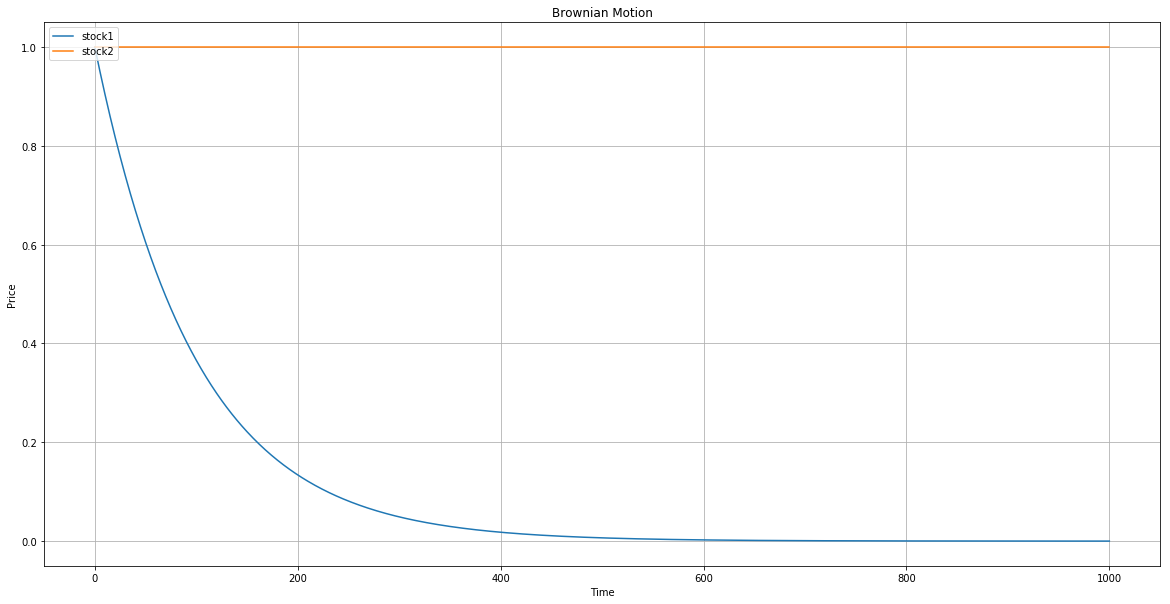

In [52]:
#Plot the market
Ts = np.arange(T+1)
plt.figure(figsize=(20,10))
plt.plot(Ts, s1, label="stock1")
plt.plot(Ts, s2, label="stock2")
#plt.plot(Ts, s3, label="stock3")
#plt.ylim(0,1000)
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid()
plt.title("Brownian Motion")
#plt.title("Toy")
plt.legend(loc=2)
plt.show()

In [53]:
D = 2.0
G = 2.0
SOM_p, SOM_reward = Second_Order_Method(assets, D, G)
FOM_p, FOM_reward = First_Order_Method(assets, D, G)
EG_p, EG_reward = EG_Strategy_general(assets)
UCRP_reward = UniformConstantRebalancedPortfolio_general(assets)
Uni_p, Uni_reward, balance_reward, Uni_regret = Universal_Portfolio(s1, s2, 40, T)
#BCRP_p, BCRP_reward = BCRP_cvx(asset)
#print(EG_p)

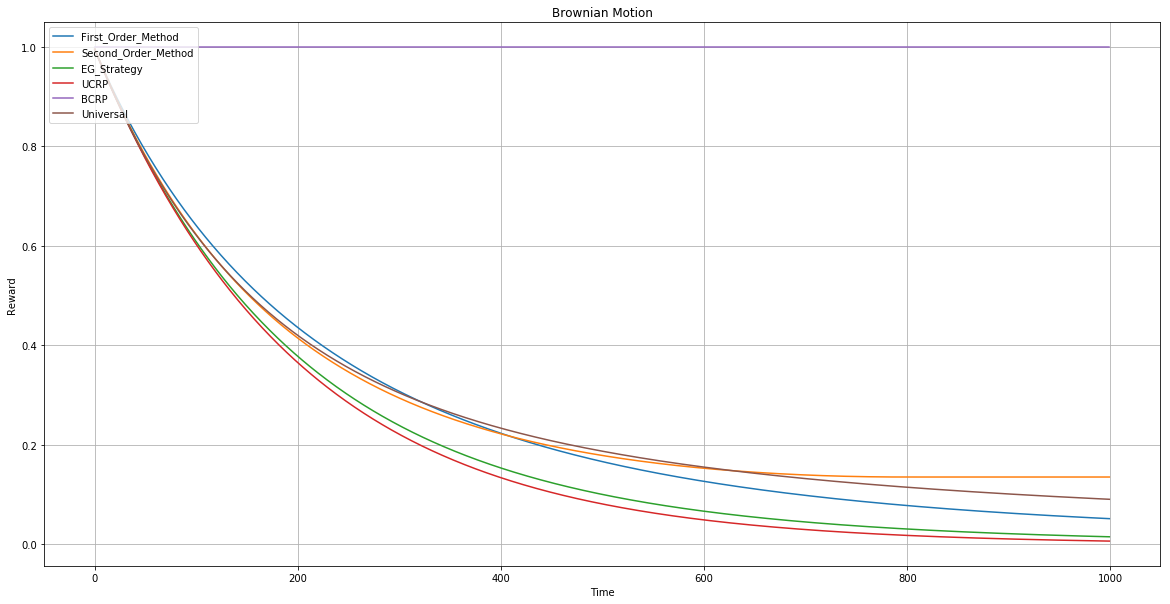

In [54]:
Ts = np.arange(T)
plt.figure(figsize=(20,10))
plt.plot(Ts, FOM_reward, label="First_Order_Method")
plt.plot(Ts, SOM_reward, label="Second_Order_Method")
plt.plot(Ts, EG_reward, label="EG_Strategy")
plt.plot(Ts, UCRP_reward, label="UCRP")
plt.plot(Ts, balance_reward, label="BCRP")
plt.plot(Ts, Uni_reward, label="Universal")
#plt.ylim(0,1000)
plt.xlabel("Time")
plt.ylabel("Reward")
plt.grid()
plt.title("Brownian Motion")
#plt.title("Fluctuation")
plt.legend(loc=2)
plt.show()

In [55]:
print(FOM_p)

[[0.5        0.5       ]
 [0.49498103 0.50501897]
 [0.49142967 0.50857033]
 ...
 [0.19042944 0.80957056]
 [0.19027345 0.80972655]
 [0.19011756 0.80988244]]
